In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import os
import joblib # For saving ML models

# Create directories for saving models
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 1. Data Acquisition
print("Loading dataset...")
dataset = load_dataset("tweet_eval", "sentiment")

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

X_train_raw = train_df['text'].tolist()
y_train = train_df['label'].tolist()
X_test_raw = test_df['text'].tolist()
y_test = test_df['label'].tolist()

print(f"Training set size: {len(X_train_raw)}, Test set size: {len(X_test_raw)}")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Training set size: 45615, Test set size: 12284


In [2]:
# Logistic Regression with TF-IDF
print("\n--- Training Model 1: Logistic Regression (TF-IDF) ---")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Feature Extraction
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

# Training
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")

# --- SAVE MODEL (REQUIRED) ---
print("Saving Logistic Regression model...")
joblib.dump(lr_model, 'checkpoints/lr_model.pkl')
joblib.dump(vectorizer, 'checkpoints/tfidf_vectorizer.pkl')


--- Training Model 1: Logistic Regression (TF-IDF) ---
Logistic Regression Accuracy: 0.5961
Saving Logistic Regression model...


['checkpoints/tfidf_vectorizer.pkl']

In [3]:
# LSTM with Embeddings
print("\n--- Training Model 2: LSTM (Deep Learning) ---")
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Tokenization
tokenizer_lstm = {word: i+1 for i, word in enumerate(set(" ".join(X_train_raw).split()))}
vocab_size = len(tokenizer_lstm) + 1
max_len = 50

def encode_text(text_list, tokenizer, max_len):
    encoded = []
    for text in text_list:
        tokens = [tokenizer.get(w, 0) for w in text.split()]
        if len(tokens) < max_len:
            tokens += [0] * (max_len - len(tokens)) # Padding
        else:
            tokens = tokens[:max_len]
        encoded.append(tokens)
    return torch.tensor(encoded, dtype=torch.long)

X_train_lstm = encode_text(X_train_raw, tokenizer_lstm, max_len)
X_test_lstm = encode_text(X_test_raw, tokenizer_lstm, max_len)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64, output_dim=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden[-1])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = SimpleLSTM(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

train_dataset = torch.utils.data.TensorDataset(X_train_lstm, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train Loop
for epoch in range(5):
    lstm_model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
lstm_model.eval()
with torch.no_grad():
    outputs = lstm_model(X_test_lstm.to(device))
    _, y_pred_lstm = torch.max(outputs, 1)
    y_pred_lstm = y_pred_lstm.cpu().numpy()

acc_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"LSTM Accuracy: {acc_lstm:.4f}")

# --- SAVE MODEL (REQUIRED) ---
print("Saving LSTM model...")
torch.save(lstm_model.state_dict(), 'checkpoints/lstm_model.pth')
# Save vocab (needed for demo)
import pickle
with open('checkpoints/lstm_vocab.pkl', 'wb') as f:
    pickle.dump(tokenizer_lstm, f)


--- Training Model 2: LSTM (Deep Learning) ---
LSTM Accuracy: 0.4833
Saving LSTM model...


In [4]:
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

print("\n--- Preparing Data for DistilBERT ---")
# Reload dataset to ensure clean state
dataset = load_dataset("tweet_eval", "sentiment")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]
val_dataset = tokenized_datasets["validation"]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results_full',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch", # Save checkpoints during training
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("--- Starting DistilBERT Training ---")
trainer.train()

print("\n--- Final Evaluation ---")
test_results = trainer.predict(test_dataset)
print(test_results.metrics)

# --- SAVE MODEL (REQUIRED) ---
print("Saving DistilBERT model...")
# Saving to checkpoints folder for submission
model.save_pretrained("checkpoints/distilbert_sentiment")
tokenizer.save_pretrained("checkpoints/distilbert_sentiment")


--- Preparing Data for DistilBERT ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


--- Starting DistilBERT Training ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.598700,0.624117,0.733500,0.732523,0.747524,0.733500
2,0.457100,0.655380,0.739000,0.738914,0.739257,0.739000



--- Final Evaluation ---


{'test_loss': 0.6664260029792786, 'test_accuracy': 0.6988765874308043, 'test_f1': 0.697714592033383, 'test_precision': 0.7014280428863592, 'test_recall': 0.6988765874308043, 'test_runtime': 178.2351, 'test_samples_per_second': 68.92, 'test_steps_per_second': 1.077}
Saving DistilBERT model...


('checkpoints/distilbert_sentiment/tokenizer_config.json',
 'checkpoints/distilbert_sentiment/special_tokens_map.json',
 'checkpoints/distilbert_sentiment/vocab.txt',
 'checkpoints/distilbert_sentiment/added_tokens.json')

DistilBERT Accuracy: 0.6989


/tmp/ipython-input-68745297.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


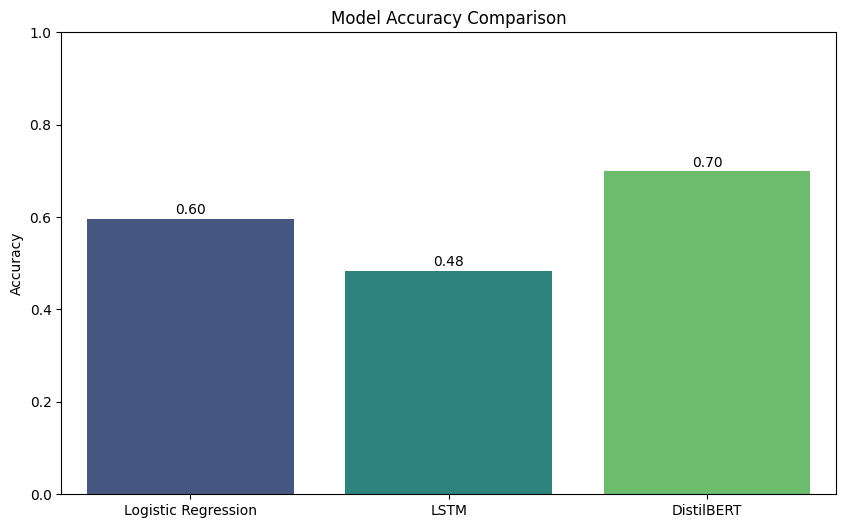


DistilBERT Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.66      0.69      3972
     Neutral       0.68      0.76      0.72      5937
    Positive       0.72      0.61      0.66      2375

    accuracy                           0.70     12284
   macro avg       0.71      0.68      0.69     12284
weighted avg       0.70      0.70      0.70     12284



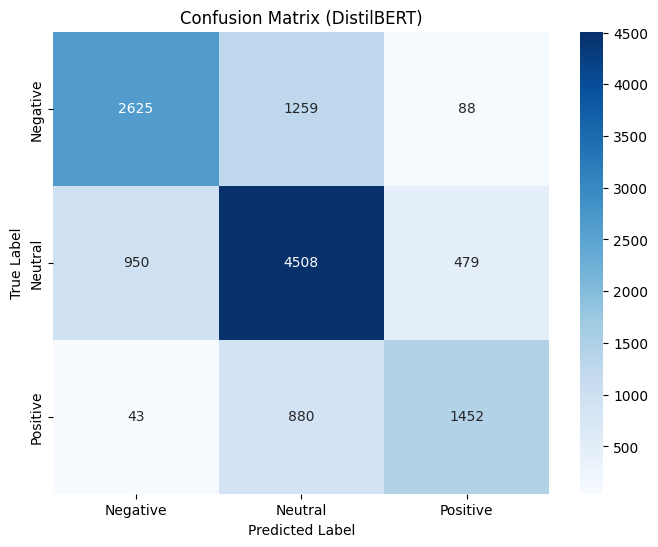

In [5]:
acc_bert = test_results.metrics['test_accuracy']
y_pred_bert = np.argmax(test_results.predictions, axis=-1)
y_test_bert = test_results.label_ids

print(f"DistilBERT Accuracy: {acc_bert:.4f}")

# Compare Models
models = ['Logistic Regression', 'LSTM', 'DistilBERT']
accuracies = [acc_lr, acc_lstm, acc_bert]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.savefig('results/accuracy_comparison.png') # Save result
plt.show()

# Classification Report
print("\nDistilBERT Classification Report:")
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test_bert, y_pred_bert, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_test_bert, y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (DistilBERT)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('results/confusion_matrix.png') # Save result
plt.show()